# Método Variacional (VQE)
#### “Nature isn't classical, dammit, and if you want to make a simulation of nature, you'd better make it quantum mechanical, and by golly it's a wonderful problem, because it doesn't look so easy.”
Richard Feynman

In [1]:
from sympy.interactive import printing
from sympy.physics.quantum.state import Ket, Bra
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum.state import Ket, Bra
printing.init_printing(use_latex = True)
import numpy as np
import simpy as sp



Partindo da equação de Schroedinger independente do tempo para um estado ligado temos:

$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$


$$\hat{H}\ket{\psi} = E_{n}\ket{\psi}$$
Onde ${\ket{n}, n = 0,1,2,3,...}$ forma base ortogonal ou seja $\delta_{nm} = \braket{n}{m}$ , então qualquer estado físico que satisfaça as condições de contorno (fisicamente adequadas) pode ser escrito como:

$$ \ket{\psi} = \sum_{n} C_{n} \ket{n} $$  
$$\sum_{n} |C_{n}|^2  = 1$$

Ou seja , escrevemos o problema do nosso estado em uma base conhecida.O valor médio de energia é dado por :

$$ \bra{\psi}\hat{H}\ket{\psi} = \sum_{m,n} C_{m}^{*}C_{n} \bra{m}\hat{H}\ket{n} = \sum_{m,n} C_{m}^{*}C_{n} E_n \bra{m}\ket{n} = \sum_{m,n} C_{m}^{*}C_{n} E_n \delta_{nm} = \sum_{m,n} C_{n}^{*}C_{n} E_n = \sum_{m,n} |C_{n}|^{2} E_n \geqslant E_{0} $$

Onde $ E_{0}$ é a energia exata do estado fundamental.O método variacional é excelente para resolver o estado fundamental de sistemas quânticos,portanto para calcular o estado fundamental de um sistema podemos seguir a seguinte receita : 

#### 1) Ansatz :
Baseado na forma do problema fazer um ansatz adequado com um parâmetro ajustável $ \alpha_{1},\alpha_{2},\alpha_{3},...,\alpha_{n},$ adequado ao problema , no caso do cálculo do estado fundamental da molécula o parâmetro que será levado em conta é a distância $r$ ; 
#### 2) Cálculo da energia:
Em seguida calcule calcule a energia : $\large{ E_{0}(r) = \frac{\bra{\psi(r)~}\hat{H}\ket{~\psi(r)}}{~\braket{\psi(r)~}{~\psi(r)}}}$

#### 3) Achar mínimos:
Calcule os mínimos da função:  $\large{ \partial_{r}E_{0}(r) = 0} $

#### 4) Calcular a energia: 
Finalmente basta calcular: $\large{E_{0}(r_{0})}$.

## Esquema do Algoritmo de VQE ?

<div>
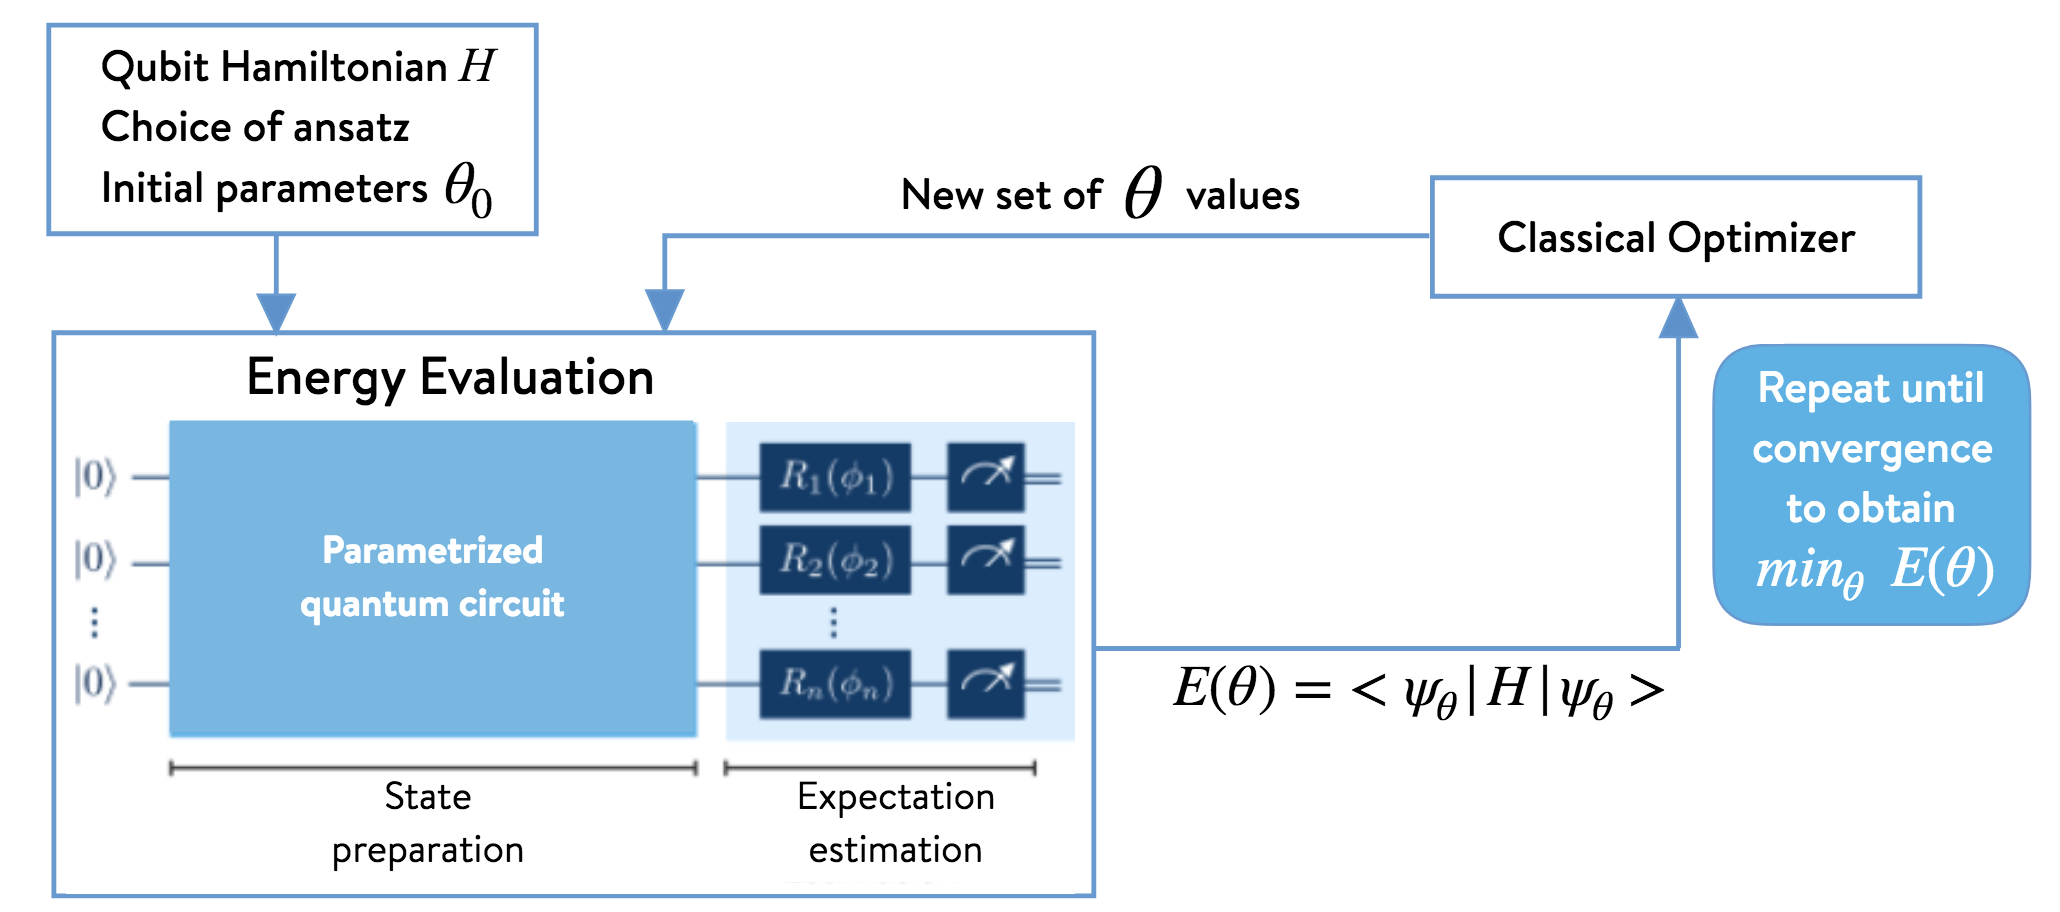
</div>


## Como implementar o algoritmo VQE (Variational Quantum Eingensolver) utilizando o pacote Qiskit ?

#### Precisamos escolher as componentos do algoritimo do VQE : 

#### 1. Optimizers (Otimizadores )
Para que server um otimizador ? 
Um otimizador server para ajustar calcular o mínimo de energia do parâmetro e criar um novo ansatz melhor que o anterior , dessa forma guiando o sistema de forma eficiente a convergência. Este é um problema de machine learning bastante complicado por si só , mas já existem alguns otimizadores disponíveis no pacote qiskit e alguns mais comumente usados são 
`COBYLA`, `L_BFGS_B`, `SLSQP` e `SPSA`.


#### 2. Qubit mapping ( Mapeamento )
Um dos problemas de implementar o método variacional é transformar a Hamiltoniana do problema original em uma Hamiltoniana 
em forma de Qubit , e existem alguns mapeamentos diferentes como : `parity`, `bravyi_kitaev`, `jordan_wigner` que podem inclusive reduzir a complexidade do problema.

#### 3. Initial state (Estado inicial)
Este é o seu ansatz , de onde o sistema começará a simulação , o Qiskit tem alguns estados iniciais disponíveis , o melhor estado depende do problema escolhido.
 Exemplos de estados iniciais: `init_state = Zero(qubitOp.num_qubits)` and the UCCSD initial state `HartreeFock(qubitOp.num_qubits, num_spin_orbitals, num_particles, map_type, qubit_reduction)`

#### 4. Parameterized circuit (Circuito parametrizado)
There are different choices you can make on the form of variational forms of your parameterized circuit.

`UCCSD_var_form = UCCSD(num_qubits, depth=depth, num_orbitals=num_spin_orbitals, num_particles=num_particles)`
    
`RY_var_form = RY(num_qubits, depth=depth)`
    
`RYRZ_var_form = RYRZ(num_qubits, depth=depth)`
    
`swaprz_var_form = SwapRZ(num_qubits, depth=depth)`

#### 5. Simulation backend
There are different simulation backends that you can use to perform your simulation

`backend = BasicAer.get_backend('statevector_simulator')`

`backend=Aer.get_backend('qasm_simulator')`




In [2]:
#The Variational Quantum Eigensolver
from pylab import *
from scipy import *
from pyscf import *

import numpy as np # Pacote numerico 
import copy 
import scipy as scp 
import matplotlib.pyplot as plt #Pacote de plot gráfico

# Pacotes que devem ser importados do qiskit para utilizar o VQE

from qiskit import BasicAer # simulador
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE # resolve autoestados
from qiskit.chemistry.components.initial_states import HartreeFock # estado inicial
from qiskit.chemistry.components.variational_forms import UCCSD # Circuito parametrizado
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType # mapeamento da hamiltoniana em qubit
from qiskit.aqua.components.optimizers import SLSQP #1 metodo de otimização
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/filipe/.local/lib/python3.7/site-packages/pyscf/lib/misc.py:47: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [3]:
#Definindo a molécula 
driver = PySCFDriver(atom='Li .0 .0 {0}; H .0 .0 -{0}' , charge=0, spin=0, basis='sto3g')
#"Variador" de distâncias
distances = np.arange(0.4,4.25,0.25)
# Lista de energias para cada método
vqe_energies = []
hf_energies = []
exact_energies = []
test_energies = []

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76


NameError: name 'min_x' is not defined

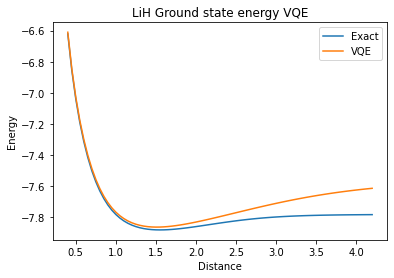

In [5]:
# THE VQE 
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
distances = np.arange(0.4,4.25,0.05)
vqe_energies = []
hf_energies = []
exact_energies = []

for i,d in enumerate(distances):
    print('step',i)
    
    #set up experiment
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g') #Escolha da base quimica
    qmolecule = driver.run()
    #Escolha do mapeamento da Hamiltoniana
    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                           two_qubit_reduction=True, freeze_core=True,
                           orbital_reduction=[-3,-2])
    qubit_op, aux_ops = operator.run(qmolecule)
    #aux_ops = operator.run(qmolecule)
    
    #exact classical result
    exact_result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
    exact_result = operator.process_algorithm_result(exact_result)
    
    #VQE 
    #otimizador clássico (machine learning)
    optimizer = SLSQP(maxiter=1000)
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                               operator.molecule_info['num_particles'],
                               qubit_mapping=operator._qubit_mapping,
                               two_qubit_reduction=operator._two_qubit_reduction)
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                    num_particles=operator.molecule_info['num_particles'],
                    initial_state=initial_state,
                    qubit_mapping=operator._qubit_mapping,
                    two_qubit_reduction=operator._two_qubit_reduction)
    algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
    
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)
    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.hartree_fock_energy)
    
plt.plot(distances,exact_energies , label='Exact')
plt.plot(distances,vqe_energies , label = 'VQE')
plt.xlabel('Distance')
plt.ylabel('Energy')
plt.title('LiH Ground state energy VQE')
plt.legend(loc = 'upper right')

#VQE min distance
min_vqe_y = min(vqe_energies)  # Find the minimum y value
min_vqe_x = distances[vqe_energies.index(min_vqe_y)]  # Find the minimum value corresponding to the maximum y value

#exact min distance
min_exact_y = min(exact_energies)  # Find the minimum y value
min_exact_x = distances[exact_energies.index(min_exact_y)]  # Find the minimum value corresponding to the maximum y value


print('--> SCF result '+str(round(min_x,3)) + ' Angstrom', str(round(min_y,4))+' Energy(eV)')
print('--> DFT result '+str(round(min_DFT_x,3)) + ' Angstrom', str(round(min_DFT_y,4))+' Energy(eV)')
print('--> VQE result '+str(round(min_vqe_x,3)) + ' Angstrom', str(round(min_vqe_y,4))+' Energy(eV)')
print('--> Exact result '+str(round(min_exact_x,3)) + ' Angstrom', str(round(min_exact_y,4))+' Energy(eV)')

--> VQE result 1.5 Angstrom -7.8634 Energy(eV)
--> Exact result 1.55 Angstrom -7.8815 Energy(eV)


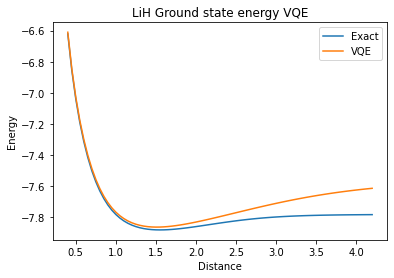

In [10]:
plt.plot(distances,exact_energies , label='Exact')
plt.plot(distances,vqe_energies , label = 'VQE')
plt.xlabel('Distance')
plt.ylabel('Energy')
plt.legend()
plt.title('LiH Ground state energy VQE')
print('--> VQE result '+str(round(min_vqe_x,3)) + ' Angstrom', str(round(min_vqe_y,4))+' Energy(eV)')
print('--> Exact result '+str(round(min_exact_x,3)) + ' Angstrom', str(round(min_exact_y,4))+' Energy(eV)')